# Combining models

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uns
from uns import training

In [50]:
models = ('400','801','802','803','804','701','702','703','704','901','902','903','904')
# assume that all of the model have the same set
validate_indices = np.where(training['model_'+models[0]] == 'validate')[0]
outputfiles = {model:uns.uns_files('validate','predictions',model) for model in models}
Nv = len(validate_indices)

In [329]:
def plot_prob_file(ax, filename, mask=False):
    p = np.load(filename)
    if mask:
        ax[1].imshow(p[1,:,:], vmin=0, vmax=1, cmap=plt.cm.gray)
    else:
        ax = [ax]
    ax[0].imshow(p[0,:,:], vmin=0, vmax=1, cmap=plt.cm.inferno)
    for a in ax:
        a.axis('equal')
        a.axis('off')
        a.tick_params(which='both', axis='both',
                       bottom=False, top=False, left=False, right=False,
                       labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        a.autoscale(tight=True)

def plot_prob(pr, gt=None, ax=None):  
    if ax is None:
        if gt is None:
            fig, ax = subplots()
        else:
            fig, ax = subplots(1,2)
    if gt is None:
        ax = [ax]
    
    ax[0].imshow(pr, vmin=0, vmax=1, cmap=plt.cm.inferno)
    if gt is not None:
        ax[1].imshow(gt, cmap=plt.cm.gray)
    for a in ax:
        a.axis('equal')
        a.axis('off')
        a.tick_params(which='both', axis='both',
                       bottom=False, top=False, left=False, right=False,
                       labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        a.autoscale(tight=True)
    return ax  
    
def dice(preds, truth):
    numer = 2*np.sum(np.logical_and(preds, truth), axis=(1,2))
    denom = np.sum(preds, axis=(1,2)) + np.sum(truth, axis=(1,2))
    scores = np.empty(preds.shape[0])
    scores[denom<1] = 1  # denom==0 implies numer==0
    idx = denom>0
    scores[idx] = numer[idx]/denom[idx]
    return scores

def evaluate_cutoffs(preds, masks, maskfun=lambda x:x, 
                     cutoffs=np.linspace(0.1,1.0,num=10),
                     minimumsizes = np.arange(0,4000,200)):
    filtscores = np.zeros((len(cutoffs), len(minimumsizes)))
    blank_masks = np.zeros_like(masks)
    blank_scores = dice(blank_masks, masks)
    for i,c in enumerate(cutoffs):
        predmasks = maskfun(preds>c)
        rawscore = dice(predmasks, masks)
        predpix = np.sum(predmasks, axis=(1,2))
        for j,m in enumerate(minimumsizes):
            predictblank = predpix<m
            minscores = np.where(predictblank, blank_scores, rawscore)
            filtscores[i,j] = np.mean(minscores)
    return cutoffs, minimumsizes, filtscores

def evaluate_cutoff(preds, masks, predictblank,
                     cutoffs=np.linspace(0.1,1.0,num=10)):
    filtscores = np.zeros(len(cutoffs))
    blank_masks = np.zeros_like(masks)
    blank_scores = dice(blank_masks, masks)
    for i,c in enumerate(cutoffs):
        predmasks = preds>c
        rawscore = dice(predmasks, masks)
        predpix = np.sum(predmasks, axis=(1,2))
        minscores = np.where(predictblank, blank_scores, rawscore)
        filtscores[i] = np.mean(minscores)
    return cutoffs, filtscores


def model_average(models, indices, weights=np.ones(100)):
    Pavg = []
    gt_masks = []
    for j in indices:
        P = []
        for m,w in zip(models, weights):
            record = np.load(outputfiles[m][j])
            P.append(record[0]*w)

        Pavg.append(np.mean(P, axis=0))
        gt_masks.append(record[1])
    return np.array(Pavg), np.array(gt_masks)

def load_model(model, indices):
    Pr = []
    GT = []
    for i in indices:
        record = np.load(outputfiles[model][i])
        Pr.append(record[0])
        GT.append(record[1])
    return np.array(Pr), np.array(GT)
  

def plot_model_dice(Pavg, gt_masks, ax=None, title=None, **kwargs):
    cutoffs, minimumsizes, filtscores = evaluate_cutoffs(Pavg, gt_masks, **kwargs)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))
    lh = ax.plot(minimumsizes, filtscores.T)
    ax.legend(['{:.1f}'.format(c) for c in cutoffs])
    ax.set_xlabel('Minimum mask size')
    ax.set_ylabel('Score')
    if title is not None:
        ax.set_title(title)
    return lh

## Plot model probabilities and ground truth

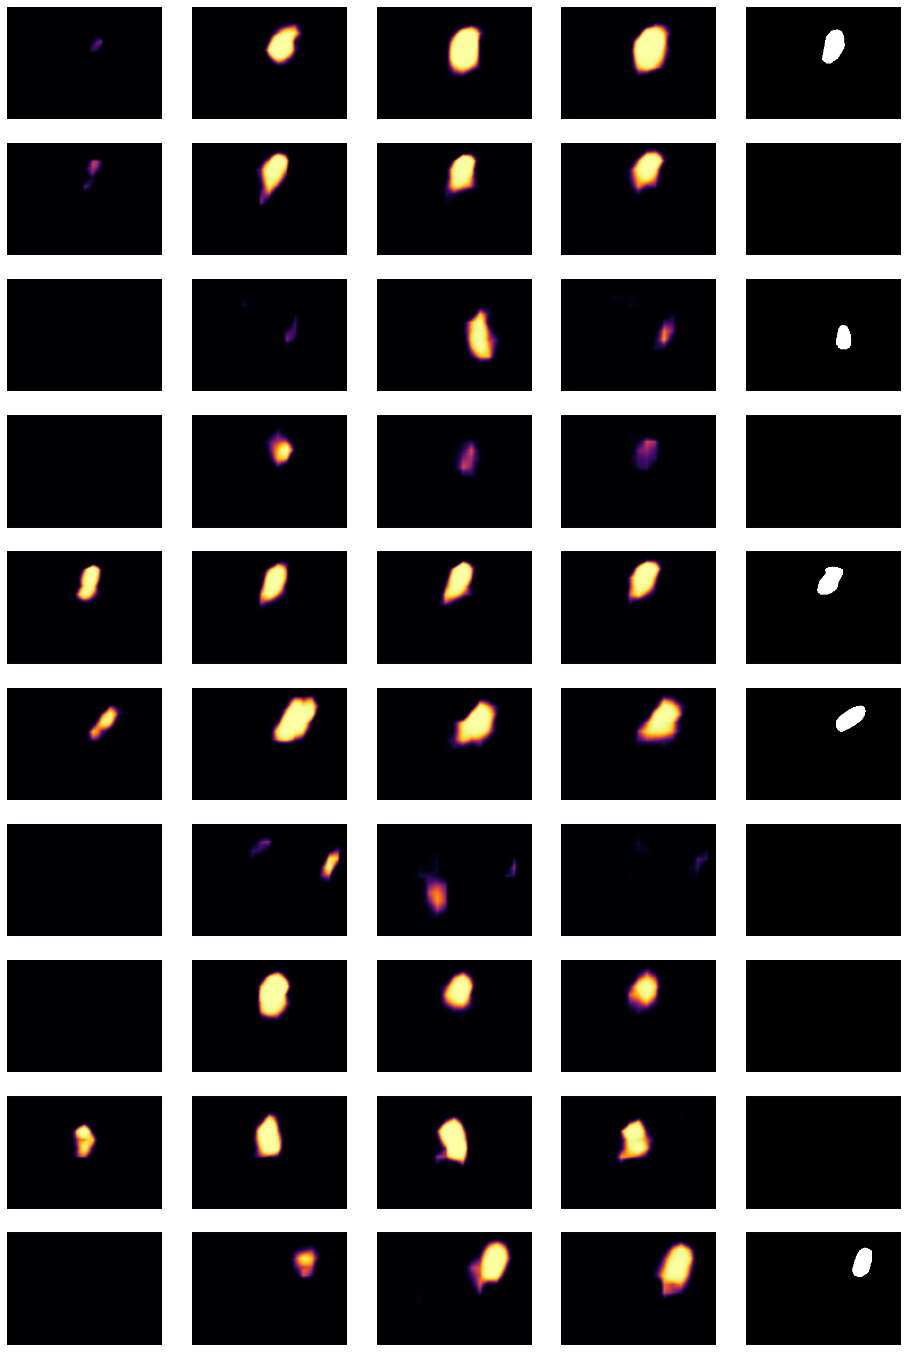

In [9]:
N = 10
fig, ax = plt.subplots(N,len(models)+1, figsize=(16,16/(len(models)+1)*3/4*N))
subset = np.random.choice(np.arange(Nv), N)
for j,jdx in enumerate(subset):
    for i,m in enumerate(models):
        if i==0:
            plot_prob_file([ax[j,i], ax[j,-1]], outputfiles[m][jdx], mask=True)
        else:
            plot_prob_file(ax[j,i], outputfiles[m][jdx])
      

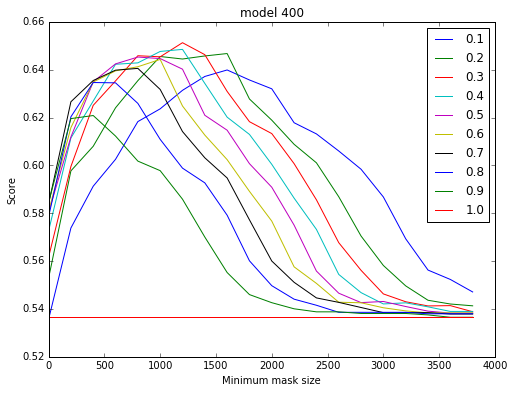

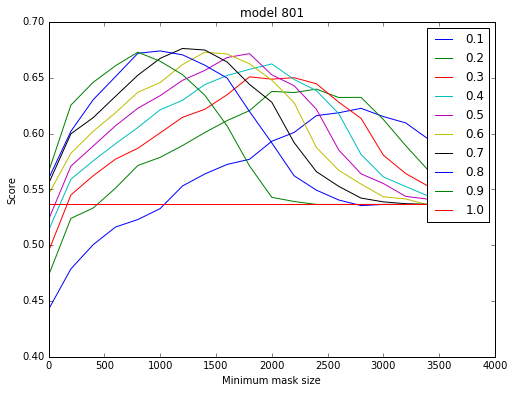

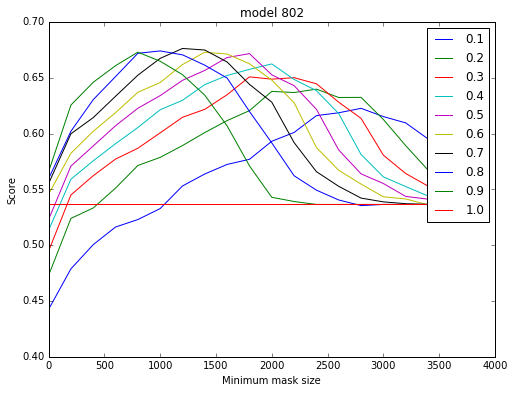

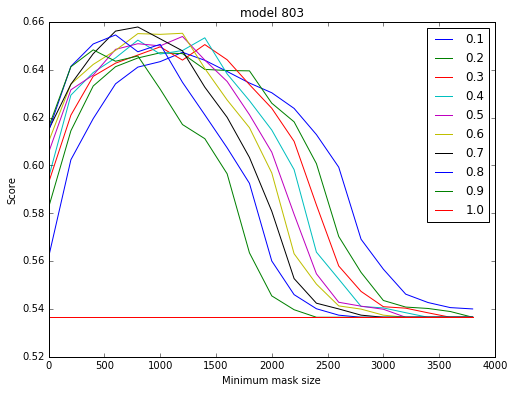

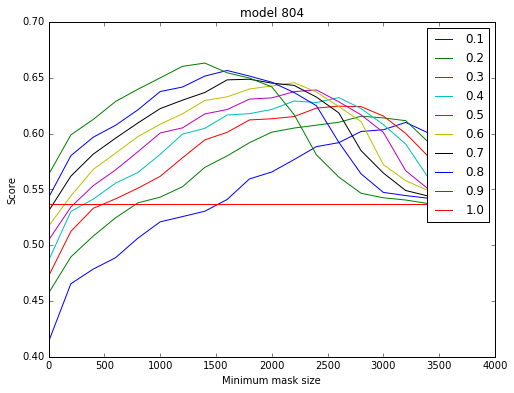

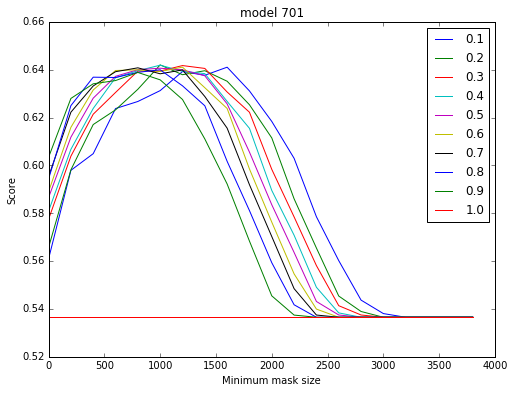

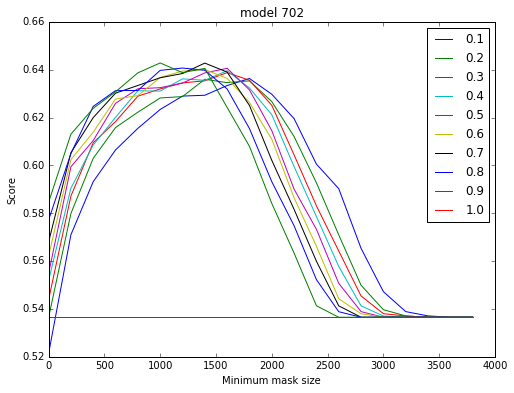

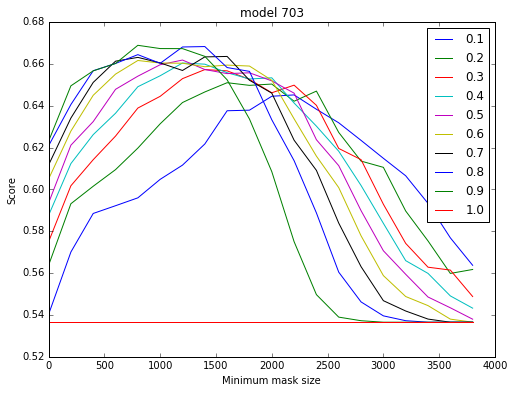

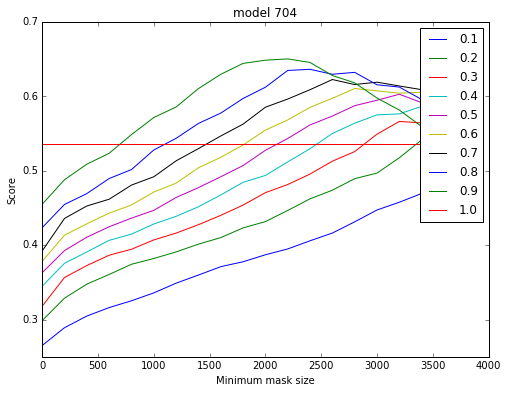

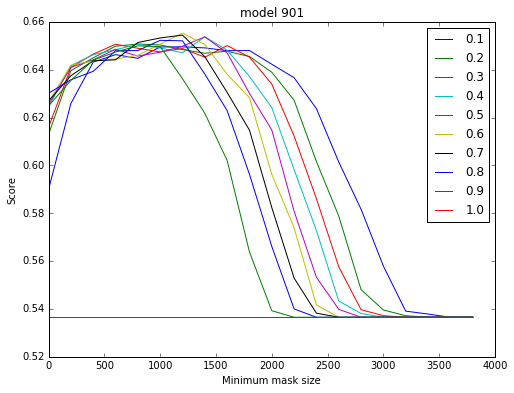

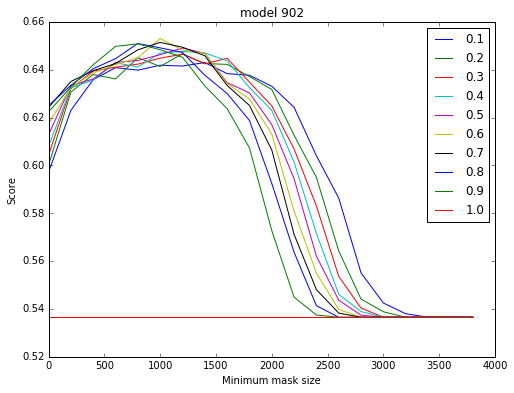

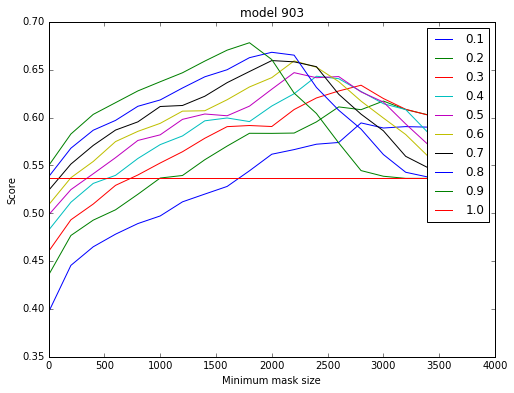

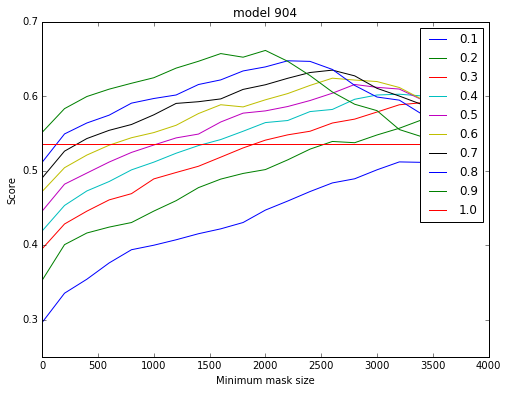

In [51]:
for model in models:
    pr, gt = load_model(model, np.arange(Nv))
    plot_model_dice(pr, gt, title='model ' + model)
    plt.show()

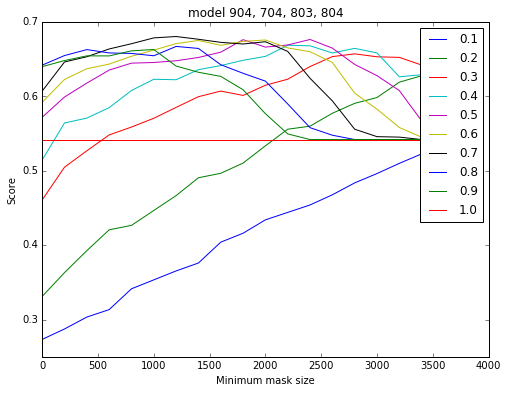

In [20]:
combo = ['904','704','803','804']
Pavg, gt_masks = model_average(combo, np.random.choice(np.arange(Nv), 500, replace=False) )
plot_model_dice(Pavg, gt_masks, title='model ' + ', '.join(combo))
plt.show()

## Combine models with different weights then produce the output

In [31]:
# use a random subset to start:
N = 500
subset = np.random.choice(np.arange(len(outputfiles[models[0]])), N, replace=False)

#load the files into memory
Pr = {}
for model in models:
    Pr[model], GT = load_model(model, subset)


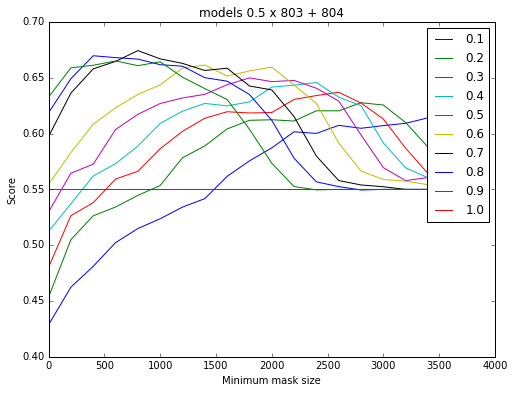

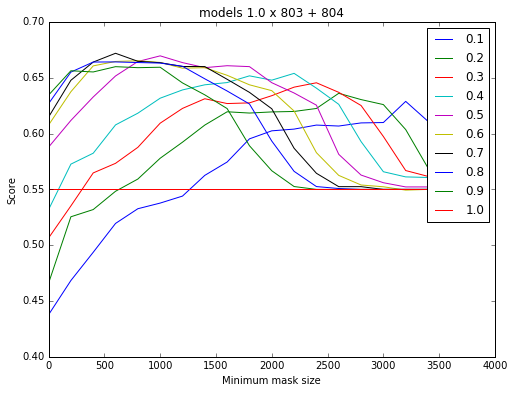

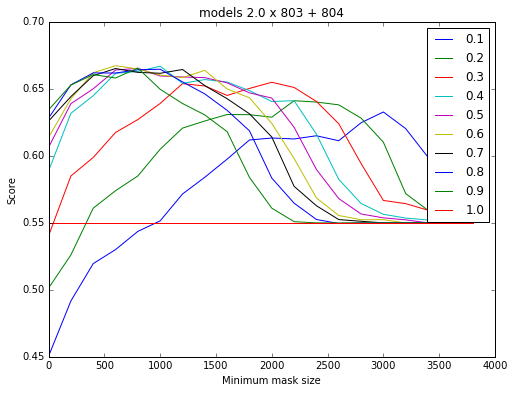

KeyboardInterrupt: 

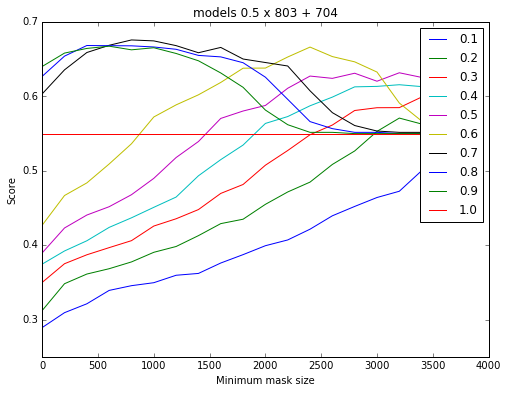

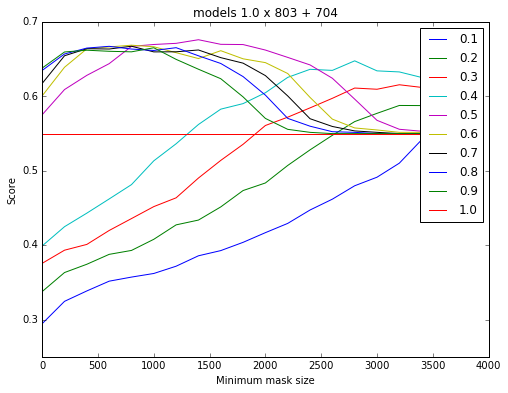

In [32]:
# Pairwise combinations
pairs = []
for im,m1 in enumerate(models):
    othermodels = [m for m in models[im:] if (m!=m1)]
    for m2 in othermodels:
        pairs.append((m1,m2))

# only need to apply weights to one of the pairs
weights = [0.5, 1.0, 2.0]
plt.close('all')
for pair in pairs:
    #pltsubset = np.random.choice(np.arange(len(subset)),20)
    model_average(pair, subset)
    for weight in weights:
        P1 = Pr[pair[0]] * weight / (1+weight)
        P2 = Pr[pair[1]] / (1+weight)
        Pavg = P1 + P2
        plot_model_dice(Pavg, GT, title='models {:.1f} x {} + {}'.format(weight, pair[0], pair[1]))
#    for im in pltsubset:
#        fig, ax = plt.subplots(1,2, figsize=(4,1.5))
#        #plot_prob(P1[im,:,:],ax=ax[0])
#        plot_prob(Pavg[im,:,:],GT[im,:,:],ax=ax)
    plt.show()


### Combine models to predict mask/no mask

In [52]:
Pr = {}
for model in models:
    Pr[model], GT = load_model(model, np.arange(Nv))

In [53]:
cutmin = {'400':(0.4,1000),
          '701':(0.5,1000), '702':(0.7,1000), '703':(0.9,1000), '704':(0.9,2000), 
          '801':(0.8,1000), '802':(0.7,1200), '803':(0.7,800), '804':(0.9,1400), 
          '901':(0.5,1000), '902':(0.6,1000), '903':(0.9,1700), '904':(0.9,1800)}

ismask = np.empty((Nv,len(models)),dtype=np.bool)
gthasmask = training.ix[validate_indices,'hasmask'].values

for im, m in enumerate(models):
    ismask[:,im]=[np.count_nonzero(p)>cutmin[m][1] for p in Pr[m]>cutmin[m][0]]

(array([ 310.,    0.,    0.,   63.,    0.,    0.,    0.,   31.,    0.,
           0.,    0.,   31.,    0.,    0.,    0.,   15.,    0.,    0.,
           0.,   19.,    0.,    0.,    0.,    9.,    0.,    0.,   14.,
           0.,    0.,    0.,    5.,    0.,    0.,    0.,    3.,    0.,
           0.,    0.,    3.,    0.,    0.,    0.,    5.,    0.,    0.,
           0.,    2.,    0.,    0.,    4.]),
 array([  0.  ,   0.26,   0.52,   0.78,   1.04,   1.3 ,   1.56,   1.82,
          2.08,   2.34,   2.6 ,   2.86,   3.12,   3.38,   3.64,   3.9 ,
          4.16,   4.42,   4.68,   4.94,   5.2 ,   5.46,   5.72,   5.98,
          6.24,   6.5 ,   6.76,   7.02,   7.28,   7.54,   7.8 ,   8.06,
          8.32,   8.58,   8.84,   9.1 ,   9.36,   9.62,   9.88,  10.14,
         10.4 ,  10.66,  10.92,  11.18,  11.44,  11.7 ,  11.96,  12.22,
         12.48,  12.74,  13.  ]),
 <a list of 50 Patch objects>)

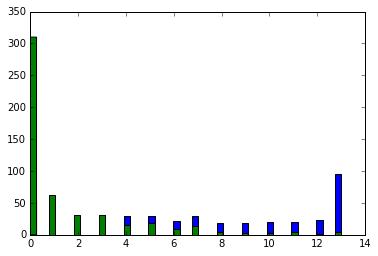

In [54]:
score = np.sum(ismask,axis=1)
fig, ax = plt.subplots()
ax.hist(score[gthasmask], bins=50)
ax.hist(score[np.logical_not(gthasmask)], bins=50)


In [108]:
# Prediction rates
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
scoring = np.array([[0.75,0],[0,1]])
for threshold in np.arange(len(models)):
    cm = confusion_matrix(score>threshold,gthasmask,labels=[True, False])/len(gthasmask)
    estdice = np.sum(cm*scoring)
    print("# models agree: {:d}, est. dice ={:.2f} ".format(threshold, estdice))

# models agree: 0, est. dice =0.63 
# models agree: 1, est. dice =0.67 
# models agree: 2, est. dice =0.68 
# models agree: 3, est. dice =0.69 
# models agree: 4, est. dice =0.69 
# models agree: 5, est. dice =0.68 
# models agree: 6, est. dice =0.67 
# models agree: 7, est. dice =0.67 
# models agree: 8, est. dice =0.66 
# models agree: 9, est. dice =0.65 
# models agree: 10, est. dice =0.63 
# models agree: 11, est. dice =0.62 
# models agree: 12, est. dice =0.61 


In [147]:
fTrue = np.sum(gthasmask)/len(gthasmask)
fFalse = 1-fTrue
scoring = np.array([[0.75,0],[0,1]])
cutoffs = np.linspace(0.4,0.9,21)
minsizes = np.arange(500,2000,50)

(0.46346555323590816, 0.53653444676409179)

In [188]:
info_dict = []
for im, m in enumerate(models):
    print('Model' + m, end='')
    for cutoff in cutoffs:
        print('.', end='')
        testpred = Pr[m]>cutoff
        for minsize in minsizes:
            row = {}
            ismask=[np.count_nonzero(p)>minsize for p in testpred]
            cm = confusion_matrix(ismask,gthasmask,labels=[True, False])/len(gthasmask)
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            estdice = np.sum(cm*scoring)
            row['model'] = m
            row['cutoff'] = cutoff
            row['minsize'] = minsize
            row['cm'] = cm_normalized
            row['dice_est'] = estdice
            info_dict.append(row)
    print('')
    

Model400.....................
Model801.....................
Model802.....................
Model803.....................
Model804.....................
Model701.....................
Model702.....................
Model703.....................
Model704.....................
Model901.....................
Model902.....................
Model903.....................
Model904.....................


In [189]:
info = pd.DataFrame(info_dict)

In [207]:
info.to_msgpack('modelinfo.mp')

In [216]:
info = pd.read_msgpack('modelinfo.mp')

In [233]:
info['PPV'] = 0.0
info['NPV'] = 0.0
info['Accuracy'] = 0.0
info['PP'] = 0.0
for i,row in info.iterrows():
    if i % int(len(info)/10)==0: 
        print('.',end='')
    cm = row['cm']
    total = np.sum(cm)
    info.set_value(i, 'PPV', cm[0,0]/(cm[0,0]+cm[1,0]))
    info.set_value(i, 'NPV', cm[1,1]/(cm[0,1]+cm[1,1]))
    info.set_value(i, 'Accuracy', 0.5*(cm[0,0] + 0.5*cm[1,1]))
    info.set_value(i, 'PP', (cm[0,0]+cm[1,0])/total)

..........

In [266]:
model_info = info.groupby(by='model')
top_models = pd.DataFrame(columns = ['PPV', 'NPV', 'Acc'],index=models)
top_models['iPPV'] = 0
top_models['iNPV'] = 0
top_models['iAcc'] = 0


(0.0, 1.0, 0.0, 1.0)

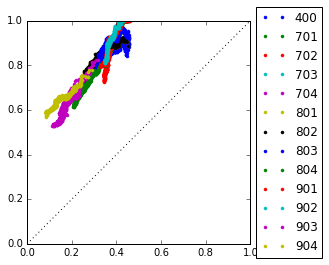

In [267]:
fig, ax = plt.subplots()
for m, g in model_info:
    iP = g['PPV'].idxmax()
    iN = g['NPV'].idxmax()
    iA = g['Accuracy'].idxmax()
    top_models.ix[m,'iPPV'] = iP
    top_models.ix[m,'iNPV'] = iN
    top_models.ix[m,'iAcc'] = iA
    top_models.ix[m, 'PPV'] = g.ix[iP,'PPV']
    top_models.ix[m, 'NPV'] = g.ix[iN,'NPV']
    top_models.ix[m, 'Acc'] = g.ix[iA,'Accuracy']
    TP = [cm[0,0] for cm in g['cm']]
    FP = [cm[1,0] for cm in g['cm']]
    ax.plot(FP,TP,'.',label=m)
ax.plot([0,1],[0,1],':k')
ax.legend(loc='center left', bbox_to_anchor=[1,0.5])
ax.axis('square')

In [270]:
top_models.to_msgpack('topmodels.mp')
top_models

,PPV,NPV,Acc,iPPV,iNPV,iAcc
400,0.735877,0.890831,0.607436,1,626,582
801,0.775223,0.886493,0.609383,630,1257,1246
802,0.775223,0.886493,0.609383,1260,1887,1876
803,0.727557,0.948258,0.630511,2310,2513,2364
804,0.754726,0.786317,0.574001,2820,3149,3149
701,0.709188,1,0.643897,3553,3359,3743
702,0.708239,0.949854,0.628346,4397,4409,4409
703,0.738952,0.928236,0.626558,4480,5039,5039
704,0.824556,0.746063,0.562361,5070,5668,5668
901,0.716833,1,0.644707,6163,6059,6117


### Iterate over each image, predict mask based on conditions above

In [280]:
#Create a score for yes/no.  Pick the highest.
Pscores = np.zeros((Nv))
Nscores = np.zeros((Nv))
for m in models:
    for idxinfo, col_info in zip(('iPPV','iNPV','iAcc'),('PPV','NPV','Acc')):
        idx = top_models.ix[m][idxinfo]
        cutoff = info.ix[idx, 'cutoff' ]
        minsize = info.ix[idx, 'cutoff' ]
        ismask=[np.count_nonzero(p)>minsize for p in Pr[m]>cutoff]
        Pscores = Pscores + np.array(ismask) * info.ix[idx, 'PPV'] * info.ix[idx,'PP']
        Nscores = Nscores + np.logical_not(np.array(ismask)) * info.ix[idx, 'NPV'] * (1-info.ix[idx,'PP'])


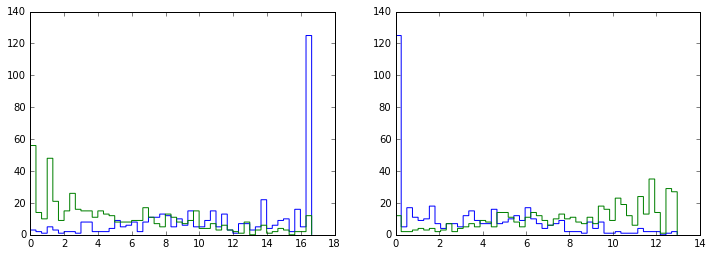

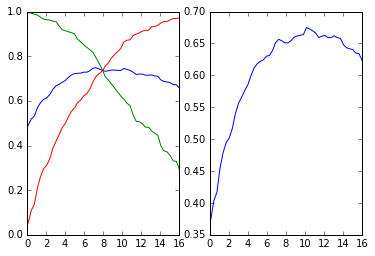

In [323]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].hist(Pscores[gthasmask],bins=50,histtype='step')
ax[0].hist(Pscores[~gthasmask],bins=50,histtype='step')
ax[1].hist(Nscores[gthasmask],bins=50,histtype='step')
ax[1].hist(Nscores[~gthasmask],bins=50,histtype='step')

bestdice = np.where(gthasmask, 0.75, 1)

weights = np.linspace(0.1,16,50)
accuracy = np.zeros_like(weights)
PPR = np.zeros_like(weights) 
NPR = np.zeros_like(weights)
estimateddice = np.zeros_like(accuracy)
for i,Pweight in enumerate(weights):
    Ppredict = Pscores>Pweight
    predictions = Ppredict
    accuracy[i] = np.sum(predictions==gthasmask)/len(gthasmask) 
    PPR[i] = np.sum(np.logical_and(predictions,gthasmask))/np.sum(gthasmask)
    NPR[i] = np.sum(np.logical_and(np.logical_not(predictions), 
                                   np.logical_not(gthasmask)))/np.sum(np.logical_not(gthasmask))
    estimateddice[i] = np.mean(bestdice * (predictions==gthasmask))
    
fig,ax = plt.subplots(1,2)
ax[0].plot(weights, accuracy)
ax[0].plot(weights, PPR)
ax[0].plot(weights, NPR)
ax[1].plot(weights, estimateddice)

plt.show()

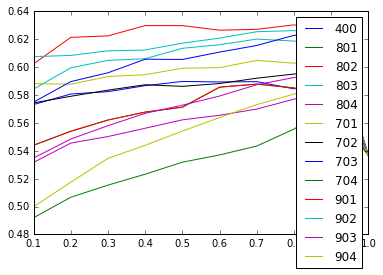

In [334]:
#Set the minimum score = 9
for m in models:
    predictblank = Nscores>9
    cutoffs, scores = evaluate_cutoff(Pr[m], GT, predictblank)
    plt.plot(cutoffs, scores, label=m)
plt.legend()

## Group event: weighting according to each models individual score

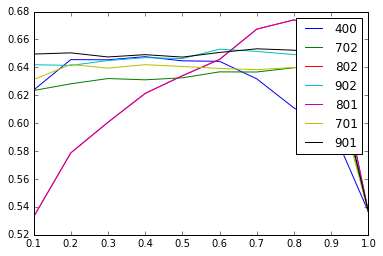

In [125]:
fig, ax = plt.subplots()
for model in models:
    m = [model]
    Pavg, gt_masks = model_average(m, indices)
    cutoffs,_,scores = evaluate_cutoffs(Pavg, gt_masks, minimumsizes=[1000])
    ax.plot(cutoffs, scores.flatten(), label=model)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

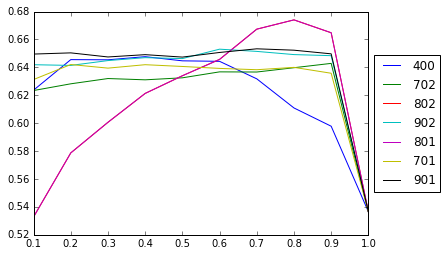

In [126]:
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig

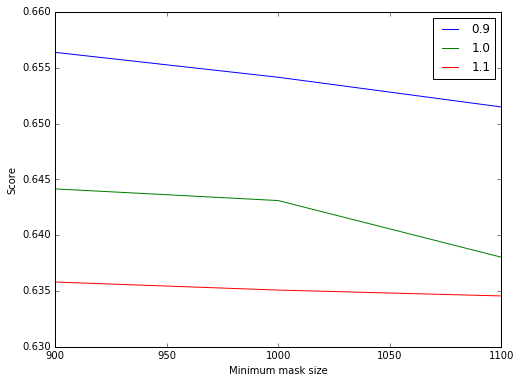

In [140]:
cutoffs = {'400':0.4,'702':0.8,'801':0.8,'802':0.8,'902':0.8,'701':0.5,'901':0.7}
weights = np.array([1/cutoffs[m] for m in models])
Pavg, gt_masks = model_average(models, indices, weights)
plot_model_dice(Pavg, gt_masks, cutoffs=[0.9,1.0,1.1], minimumsizes=[900,1000,1100])

## Probability given models

What is P(Mask|Model1,Model2,Model3,Model4)

Known:
P(Image has mask) -> fixed ~0.51
P(Models|image has mask)

P(pixel has mask) -> known from images, not independent
P(model 
P(Model1) Probability that model says any random pixel has mask ?

In [ ]:
P(m) = P(t)P(t|m)/P(m|t)

In [ ]:
N = 100
subset = np.random.choice(np.arange(len(outputfiles[models[0]])), N)
for j,jdx in enumerate(subset):
    for i,m in enumerate(models):
        p = np.load(outputfiles[m][jdx])
        # calculate expected area (sum probability)
        if i == 0:
            size = np.prod(p[0].shape)
            print('{:04d}: {:5.3f}'.format(jdx, np.sum(p[1])/size), end='|')
        print('{:5.3f}'.format(np.sum(p[0])/size), end='|')
    print()

(-0.0005, 0.1)

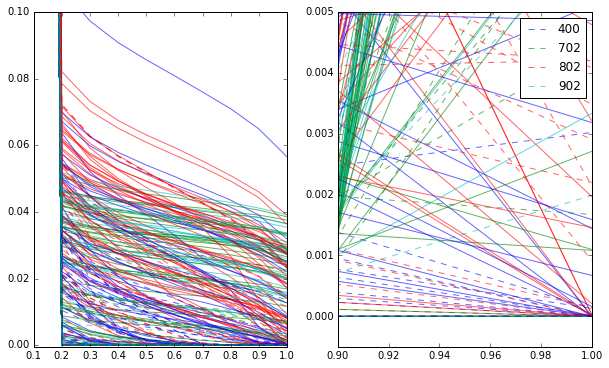

In [8]:
N = 100
fig, ax = plt.subplots(1,2, figsize=(10,6))
col = ('b','g','r','c')
subset = np.random.choice(np.arange(len(outputfiles[models[0]])), N)
leg=None
for j,jdx in enumerate(subset):
    for i,m in enumerate(models):
        p = np.load(outputfiles[m][jdx])
        hist = np.histogram(p[0],np.linspace(0,1,11))
        size = np.prod(p[0].shape)
        if np.sum(p[1]) > 0:
            ls = '-' + col[i]
        else:
            ls = '--' + col[i]
        if j==(len(subset)-1):
            leg = m
            
        ax[0].plot(hist[1][1:], np.cumsum(hist[0][::-1])[::-1]/size, ls, alpha=0.6)
        ax[1].plot(hist[1][2:], hist[0][1:]/size, ls, alpha=0.6, label=leg)
        
        #print('{:04d}: {:5.3f}'.format(jdx, np.sum(p[1])/size), end='|')
        #print('{:5.3f}'.format(np.sum(p[0])/size), end='|')
ax[1].legend() 
ax[1].set_xlim(0.9,1.0)
ax[1].set_ylim(-0.0005,0.005)

ax[0].set_ylim(-0.0005,0.1)

In [9]:
# Add new columns:
bins = np.linspace(0,1,11)
for m in models:
    for i in bins[1:]:
        columnname = 'model_{:s}_hist_{:03d}'.format(m,int(i*100))
        training[columnname] = 0
print(training.columns)

Index(['centcol', 'centrow', 'contH', 'contW', 'contour', 'contxmax',
       'contxmin', 'contymax', 'contymin', 'hasmask',
       ...
       'model_902_hist_010', 'model_902_hist_020', 'model_902_hist_030',
       'model_902_hist_040', 'model_902_hist_050', 'model_902_hist_060',
       'model_902_hist_070', 'model_902_hist_080', 'model_902_hist_090',
       'model_902_hist_100'],
      dtype='object', length=148)


In [10]:
for j,jdx in enumerate(indices):
    for i,m in enumerate(models):
        p = np.load(outputfiles[m][j])
        hist = np.histogram(p[0],np.linspace(0,1,11))
        size = np.prod(p[0].shape)
        for h,b in zip(hist[0],hist[1][1:]):
            columnname = 'model_{:s}_hist_{:03d}'.format(m,int(b*100))
            colnum = training.columns.get_loc(columnname)
            training.iloc[jdx, colnum] = h

In [13]:
training.to_msgpack('training.bin')

In [11]:
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder
# list of columns:
bins = np.linspace(0,1,11)
columns = []
for m in models:
    for i in bins[1:]:
        columns.append('model_{:s}_hist_{:03d}'.format(m,int(i*100)))


In [12]:
X = training.ix[indices,columns].values/size
X.shape

(958, 40)

In [18]:
y = training.ix[indices,'hasmask'].values
clf = svm.LinearSVC()
clf.fit(X,y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [19]:
y_pred = clf.predict(X)
classif_rate = np.mean(y_pred == y) * 100
classif_rate

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, y_pred, labels=[True, False])
print(cm)
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
print(cm_norm)

# estimate dice score based on confusion matrix:
(cm_norm[0,0]*.73 + cm_norm[1,1])/2

[[281 163]
 [ 65 449]]
[[ 0.63288288  0.36711712]
 [ 0.12645914  0.87354086]]


0.66777268026781644

In [48]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
Xp = RobustScaler().fit_transform(X)
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(Xp, y).transform(Xp)

/Users/chrisv/anaconda/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


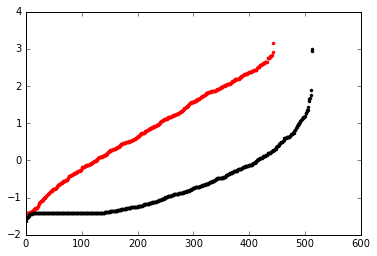

In [49]:
fig, ax = plt.subplots()
ax.plot(sorted(X_r2[y]),'.r')
ax.plot(sorted(X_r2[~y]),'.k')

In [38]:
lda.means_

array([[ 0.04400222, -0.26938399, -0.21953032, -0.09887246,  0.13002445,
         0.25680934,  0.24451908,  0.21974348,  0.17807175,  0.31773235,
        -0.2137178 ,  0.24600614,  0.33427547,  0.31815614,  0.31311945,
         0.30774338,  0.29741776,  0.27080551,  0.2620043 ,  0.22296769,
         0.3244998 , -0.37707684, -0.25484896, -0.2285841 , -0.23950102,
        -0.24135578, -0.26552494, -0.26586609, -0.22747768,  0.12652309,
        -0.19905122,  0.22159659,  0.21516969,  0.20126124,  0.19317922,
         0.19626378,  0.19129401,  0.18777793,  0.18980108,  0.58619868],
       [-0.57216323,  0.15755839,  0.25357346,  0.41710649,  0.66890854,
         0.82193959,  0.81431515,  0.79131131,  0.77947823,  2.33914309,
        -0.78459717,  0.58937596,  0.70689908,  0.68232345,  0.71013938,
         0.68003074,  0.70020475,  0.6701627 ,  0.67466935,  1.15158607,
        -0.18797186,  0.08387786,  0.09582388,  0.10485926,  0.1014974 ,
         0.12466376,  0.13164061,  0.17323358,  0.

## why are we missing masks?

In [25]:
#predicted area model_???_hist_100 vs mask area
#mask properties
# Classifier? regression?



30450000

In [73]:
cm.flatten()



array([  9.00000000e-01,   2.00000000e+03,   6.38569937e-01,
         1.84759916e-01,   3.65344468e-02,   2.78705637e-01,
         5.00000000e-01])